## Randomized benchmarking

Randomized benchmarking is a commonly-used technique for estimating the quality of a set of operations, typically the Clifford group. A state is prepared in a fixed state $|\psi \rangle$. Then a randomly-chosen sequence of noisy Cliffords is applied, followed by the Clifford that is (in the ideal case) the inverse of this sequence. Finally, the state is measured to see whether it is still in the input state $|\psi \rangle$.

The probability of the state remaining in $| \psi \rangle$ after the sequence is termed the _survival probability_. If the Cliffords are perfect, the survival probability will always be 1. However, realistically, there will be some errors. Such errors will be compounded when we go to longer and longer sequences. Thus we expect, when averaged over many randomly chosen sequences over a set of given lengths, the average survival probability will decay exponentially.

This decay rate, commonly called the 'RB number', was previously assumed to be directly related to the _average gateset infidelity_ over all the Cliffords. However, recent results by Proctor et. al have called this into question, as the RB number is a gauge-independent parameter, whereas the infidelity is a gauge-dependent parameter. We therefore must be very careful when interpreting results of the RB procedure.

In this notebook, we will

1) use OQT to characterize noisy implementations of Clifford group elements

2) use the posterior distribution obtained from OQT to perform a RB experiment.

_**Note**: To generate the data used in our paper takes a significant amount of time when run as-is. Along with the notebook, we provide output data files that were used to produce our results._

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi': 150}
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../src/")

from tqdm import tqdm

import numpy as np
np.set_printoptions(suppress = True, precision = 6)

import pandas as pd
import qinfer as qi

import oqt
from oqt.distributions import HadamardDistribution, CliffordPhaseDistribution
from oqt.heuristics import RBHeuristic
from oqt.errors import GinibreNoise

# The prefix of the path to the data files; change if you want different save/load locations
# Keep as-is if you want to use our data
prefix = "../data/rb/2020-06-04-rb-"

RB is concerned with the quality of Clifford operations. Traditional RB considers the 'base unit' of an experiment to be individual elements of the Clifford group. However, the (single-qubit) Clifford group can be generated using only the Hadamard $H$ and phase gate $S$. 

Our OQT button box will consist of 4 buttons: $\rho$, $E$, $H$, and $S$. We also want to make clear here the mapping between some of the standard RB terminology and the language we are using in OQT.

- A generator in RB corresponds to a button in OQT
- A gate in RB (i.e. a Clifford element) corresponds to a button sequence in OQT
- A sequence in RB (i.e. a product of Clifford elements) corresponds to a sequence of button sequences, which under concatenation is itself a sequence. 

The code snippet below initializes a group object with two generators and matrix multiplication as the operation (the swap function assures the matrices are multiplied in the correct order), and an equivalence function given by equality up to a phase. 

In [2]:
import oqt.groups as grp

H = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]])
S = np.array([[1, 0], [0, 1j]])

def swap(fn):
    def swapped(x, y):
        return fn(y, x)
    return swapped

cliffords = grp.Group({'H' : H, 'S' : S}, 
                      identity=np.eye(2), 
                      equivalence=grp.eq_ignore_phase, 
                      group_operation=swap(np.matmul));

RB is considered to be robust to errors in SPAM. Therefore for simplicity, we will assume that the SPAM buttons are ideal. Here we will prepare and measure the $|0\rangle$ state.

In [3]:
vec_ρ = np.array([1, 0, 0, 1]) / np.sqrt(2) # preparing |0><0|
vec_E = np.array([1, 0, 0, 1]) / np.sqrt(2) # measuring |0><0| also, software will perform prob(1) = 1 - prob(0)

ideal_spam = np.einsum("i,j->ij", vec_ρ, vec_E)

Next we specify the distributions over the unknown operators. Both $H$ and $S$ can be parameterized in terms of an angle, so we choose overrotation distributions for both of them, and add some additional Ginibre Noise. The variance was chosen in order to obtain a fidelity of roughly 0.999. (For details, see the paper).  

In [4]:
def fidelity_from_std(std):
    return 2./3 + (1./3) * np.cos(2 * std)

def std_from_fidelity(fid):
    return 0.5 * np.arccos(3 * (fid - 2./3))

In [5]:
desired_fidelity = 0.999
overrot_var = std_from_fidelity(desired_fidelity) ** 2
print(f"Overrotation variance for fidelity of {desired_fidelity} = {overrot_var:.6f}")

Overrotation variance for fidelity of 0.999 = 0.001501


In [6]:
known_operators = {'WellKnownGates.SPAM' : ideal_spam}

ginib_var = 1e-3

true_unknown_operators = {'H' : HadamardDistribution(
                                    var = overrot_var, 
                                    channel_error=GinibreNoise(eps=ginib_var)
                                ),
                          'S' : CliffordPhaseDistribution(
                                    var = overrot_var,
                                    channel_error=GinibreNoise(eps=ginib_var)
                                )
                         }

Before we set up our model, we need to figure out what fiducials to choose. A couple of bad initial guesses suggested this was not so simple - so, I used brute force (thanks to Natalie Klco for the idea!).

I took all possible combinations of 3 Cliffords and the empty sequence. I then sample 100 different instances from the prior, and attempted to construct the matrix $\tilde{F}$. Sets of fiducials that worked in over 90% of the cases were saved.

The following code does not need to be run, but we made it available for the sake of reproducibility.

In [ ]:
# # Loop through all possible combinations of non-identity fiducials; 1771 combinations (23 x 22 x 21)/3!
# counter = 0

# valid_tuples = []
# invalid_tuples = []

# for f1_idx in range(1, len(cliffords)):
#     f1 = list(cliffords._elements[f1_idx])
    
#     for f2_idx in range(f1_idx + 1, len(cliffords)):
#         f2 = list(cliffords._elements[f2_idx])
        
#         for f3_idx in range(f2_idx + 1, len(cliffords)):
#             f3 = list(cliffords._elements[f3_idx])      
        
#             param = oqt.linear_parameterization.GatesetParameterization(
#                 gateset_labels=['H', 'S'], 
#                 fiducial_labels=[[], f1, f2, f3] # What are good fiducials for this?
#             )
            
#             prior = oqt.distributions.GSTProductDistribution(param, known_operators=known_operators, unknown_operators=true_unknown_operators)

#             num_trials = 100
#             num_successes = 0
            
#             for sample_idx in range(num_trials):
#                 pr_tensor_ideal = param.modelparams_to_pr_tensor(prior.sample())
            
#                 try: 
#                     np.linalg.inv(pr_tensor_ideal['I'])
#                     num_successes += 1
#                 except:
#                     continue
                    
#             if num_successes > 0.9 * num_trials:
#                 valid_tuples.append((f1, f2, f3))
#             else:
#                 invalid_tuples.append((f1, f2, f3))        

I chose arbitrarily one of the sets from `valid_tuples`. It looks kinda nice, too. Now we can set up the parameterization, the model, and the prior.

## Perform OQT to learn the Clifford group generators

In [7]:
param = oqt.linear_parameterization.GatesetParameterization(
    gateset_labels=['H', 'S'], 
    fiducial_labels=[[], ['H'], ['H', 'S', 'H'], ['S', 'H', 'S']] 
)

model = qi.BinomialModel(oqt.linear_parameterization.GatesetModel(param))

prior = oqt.distributions.GSTProductDistribution(param, known_operators=known_operators, unknown_operators=true_unknown_operators)

Choose the true parameters by sampling the prior.

The data associated with this file uses the following samples. The true parameters are stored in `true_params` for use in subsequent runs.

```
Sampled 1 Hadamard gates:
-----------------------------------------
epsilon = -0.007797894622554719
Superoperator = 
[[ 1.      +0.j  0.      +0.j  0.      +0.j  0.      +0.j]
 [ 0.      +0.j  0.000061+0.j -0.011027+0.j  0.999939+0.j]
 [ 0.      +0.j  0.011027+0.j -0.999878+0.j -0.011027+0.j]
 [ 0.      +0.j  0.999939+0.j  0.011027+0.j  0.000061+0.j]]

Ginibre noise:
-----------------------------------------
Ginibre superoperator = 
 [[ 1.       -0.       -0.       -0.      ]
 [ 0.435103 -0.120449 -0.297836  0.062722]
 [-0.314789  0.032982 -0.089239  0.080124]
 [ 0.188424  0.101214 -0.284711  0.142465]]
Updated superoperator = 
 [[ 1.      +0.j -0.      +0.j -0.      +0.j -0.      +0.j]
 [ 0.000435+0.j -0.00006 +0.j -0.011314+0.j  0.999002+0.j]
 [-0.000315+0.j  0.011049+0.j -0.998968+0.j -0.010936+0.j]
 [ 0.000188+0.j  0.99904 +0.j  0.010732+0.j  0.000203+0.j]]

Sampled 1 phase gates (S gates):
-----------------------------------------
epsilon = -0.04739063237624944
Superoperator = 
[[ 1.        0.        0.        0.      ]
 [ 0.        0.047373 -0.998877  0.      ]
 [ 0.        0.998877  0.047373  0.      ]
 [ 0.        0.        0.        1.      ]]

Ginibre noise:
-----------------------------------------
Ginibre superoperator = 
 [[ 1.        0.       -0.        0.      ]
 [-0.256911  0.53382   0.265858  0.104777]
 [-0.018402 -0.178172  0.565879  0.061297]
 [-0.187707 -0.349921 -0.279835  0.450564]]
Updated superoperator = 
 [[ 1.        0.       -0.        0.      ]
 [-0.000257  0.047859 -0.997613  0.000105]
 [-0.000018  0.9977    0.047891  0.000061]
 [-0.000188 -0.00035  -0.00028   0.999451]]
```

In [ ]:
# To sample a new instance of H and S
# true_params = prior.sample(display_params=True)

In [8]:
# The true parameters used in the paper
true_params = np.array([
       [1.      , 0.500196, 0.534813, 0.499853, 0.999273, 0.489273,
        0.53481 , 0.489207, 0.00776 , 0.994971, 0.534842, 0.994955,
        0.00588 , 0.50076 , 0.546008, 0.489206, 0.545679, 0.992699,
        0.008128, 0.488946, 0.00796 , 0.994584, 0.999631, 0.499929,
        0.49961 , 0.50012 , 0.995343, 0.005685, 0.468087, 0.558286,
        0.499827, 0.005513, 0.558212, 0.417819]
])

Let's compute the fidelities of our sampled gates.

In [9]:
import qutip as qt 

H_sup = oqt.gates.super_hadamard()
S_sup = oqt.gates.super_rot_z(np.pi/2)

GH = np.array([[ 1.,  0, 0, 0],
 [ 0.000435+0.j, -0.00006 +0.j, -0.011314+0.j,  0.999002+0.j],
 [-0.000315+0.j,  0.011049+0.j, -0.998968+0.j, -0.010936+0.j],
 [ 0.000188+0.j,  0.99904 +0.j,  0.010732+0.j,  0.000203+0.j]])

GS = np.array( [[ 1.,        0. ,      -0.  ,      0.      ],
 [-0.000257,  0.047859, -0.997613 , 0.000105],
 [-0.000018,  0.9977 ,   0.047891 , 0.000061],
 [-0.000188, -0.00035 , -0.00028,   0.999451]])

gh_fidelity = qt.metrics.average_gate_fidelity(qt.Qobj(H_sup @ np.conj(GH.T)))
gs_fidelity = qt.metrics.average_gate_fidelity(qt.Qobj(S_sup @ np.conj(GS.T)))

print(f"GH fidelity = {gh_fidelity:.6f}")
print(f"GS fidelity = {gs_fidelity:.6f}")

GH fidelity = 0.998804
GS fidelity = 0.997907


RB, however, actually gives us the average gate fidelity when each _Clifford_ is considered as a gates and not just the two generating elements. So let's use our knowledge of the gates here to compute the average fidelity of our noisy Clifford gates.

In [10]:
from functools import reduce

true_map = {'H' : H_sup, 'S' : S_sup}
sample_map = {'H' : GH, 'S' : GS}

fid_total = 0

for element in cliffords._elements[1:]:
    true_mat = reduce(lambda x, y: y @ x, [true_map[m] for m in list(element)])
    sample_mat = reduce(lambda x, y: y @ x, [sample_map[m] for m in list(element)])
    
    fid_total += qt.metrics.average_gate_fidelity(qt.Qobj(true_mat @ np.conj(sample_mat.T)))

fid_total += 1 # Fidelity of the identity is 1, since identity is Clifford element

average_clifford_fidelity = fid_total/len(cliffords._elements)

print(f"Average Clifford fidelity = {average_clifford_fidelity:.6f}")

Average Clifford fidelity = 0.990614


## Training and Bayesian inference

**Note**: unless you want to run everything for yourself, you don't need to run any cells until the "Data Management" section further down.

Set up the particle cloud - 10000 particles worked pretty well for this.

In [11]:
# Set up the particle and SMC updater
n_particles = 10000
updater = qi.SMCUpdater(model, n_particles, prior)

Now we set up the experiment design heuristic. RB consists of randomly chosen sequences of Cliffords, and so this is what the heuristic gives us. We just need to choose a minimum and maximum sequence length, and a number of experiments, and the heuristic will produce for us a roughly equal number of sequences for each length within the range. We find that using sequences of length 40-60 gives reasonable results; we do 100 total experiments, so 5 of each length.

Now we run the experiments one by one, and perform Bayesian updates.

In [12]:
num_experiments = 100
sampled_experiments = [] # Save the experiments we did

heuristic = RBHeuristic(updater, cliffords, n_experiments=num_experiments, min_seq_len=40, max_seq_len=60)

This next cell will perform the updating; it doesn't take too long to run, and the output particle locations weights are stored in the provided data files.

In [13]:
# Run ONLY IF you want to generate your own RB data
for idx_experiment in tqdm(range(num_experiments)):
    experiment = heuristic()
    sampled_experiments.append(experiment)
    
    datum = model.simulate_experiment(true_params, experiment) # TODO
    
    with qi.perf_testing.numpy_err_policy(invalid='raise'):
        updater.update(datum, experiment)

100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


## Running RB using the OQT posterior distribution

At this point, the OQT portion is done - we have learned a posterior distribution over $H$ and $S$.
Now, we would like to use this to perform randomized benchmarking and see how good they are.

We need to choose a set of sequence lengths to test on. My intention was to choose them spaced logarithmically between 10 and somewhere around 250 - the logspace function below gives a range between 10-252. I chose only the unique values after taking the ceiling from this range.

We chose to perform 100 randomly chosen sequences at each length. Then, for each particle, we will perform this set of experiments and store the results. This will give us an 'RB curve' for each particle, and we can then combine these results over the whole posterior.

_**Note**: running this next portion may take ~6 hours. We recommend using the provided data files._

In [14]:
heuristic._mode = "test"

exp_lengths = np.unique(np.ceil(np.logspace(1, 2.4, 100)))

exps_per_point = 100

In [15]:
# Run only if you want to generate your own test experiments; 
# testing experiments are provided.
test_experiments = []
for seq_len in tqdm(list(exp_lengths)):
    test_exps_this_len = []
    for exp in range(exps_per_point):
        experiment, ret_seq_len = heuristic.arbitrary_length_experiment(int(seq_len))
        test_exps_this_len.append(experiment)
    test_experiments.append(test_exps_this_len)

100%|██████████| 87/87 [03:55<00:00,  2.71s/it]


In [16]:
#particle_locations = updater.particle_locations
#particle_weights = updater.particle_weights

# Load up the particle locations from the paper example
# unless you ran it yourself above and want to use your own version
particle_locations = np.load("../data/rb/2020-06-04-rb-particle-locations.npy")
particle_weights = np.load("../data/rb/2020-06-04-rb-particle-weights.npy")

In [17]:
# Run only if you want to generate your own data - takes about 4hrs

# In RB we want to look at how the survival probability decays with sequence length
survival_probabilities = []

outcomes = np.array([0], dtype='uint') # We want to calculate likelihood of outcome 0 for each particle in the cloud

# For each of the test experiments, at each length, compute the survival probability
# then compute the mean
for exp_length_idx in tqdm(range(len(test_experiments))):
    for idx_experiment, experiment in enumerate(test_experiments[exp_length_idx]):
        seq_probs = model.underlying_model.likelihood(outcomes, particle_locations, experiment)[0, :, 0]
        survival_probabilities.append([exp_lengths[exp_length_idx], experiment['sequence'][0].length(), seq_probs])

100%|██████████| 87/87 [3:41:28<00:00, 152.74s/it]  


In [19]:
# Now we need to separate out the data for each individual particle.
# We'll store everything in a data frame. This cell took 1-2 hrs
# to run as is, and the resulting file is 4.9 GB. This file is available 
# by request, but you can generate your own (also, there is probably a 
# faster way of making it).
columns = ['pid', 'rb_length', 'gst_length', 'prob']

df = pd.DataFrame(columns=columns)

for idx_row, row in tqdm(enumerate(survival_probabilities)):
    rb_length = row[0]
    gst_length = row[1]
    seq_probs = row[2]
    # Create a giant numpy array
    data_array = np.zeros((seq_probs.shape[0], 4))
    # Set the particle ids
    data_array[:, 0] = list(range(seq_probs.shape[0]))
    data_array[:, 1] = rb_length
    data_array[:, 2] = gst_length
    data_array[:, 3] = seq_probs
    df = df.append(pd.DataFrame(data_array, columns=columns))
    
# To make things simpler, add one extra column to the data frame 
df['success_prob'] = 1 - df['prob']
df.to_csv(prefix + "full-data.csv", index=False)

8700it [1:03:08,  2.30it/s]


## Data management

If you ran this yourself, highly recommend to save all the data given the time it takes to generate. 

In [20]:
# The experiments we used
np.save(prefix + "training_experiments.npy", sampled_experiments, allow_pickle=True)
np.save(prefix + "testing_experiments.npy", test_experiments, allow_pickle=True)

# True parameters
np.save(prefix + "true.npy", true_params)

# Posterior distribution after OQT
np.save(prefix + "particle-locations.npy", updater.particle_locations)
np.save(prefix + "particle-weights.npy", updater.particle_weights)

Alternatively, run this cell to load all the data provided.

In [ ]:
exp_lengths = np.unique(np.ceil(np.logspace(1, 2.4, 100)))

# The experiments we used
sampled_experiments = np.load(prefix + "training_experiments.npy", allow_pickle=True)
test_experiments = np.load(prefix + "testing_experiments.npy", allow_pickle=True)

# True parameters
true_params = np.load(prefix + "true.npy")

# Posterior distribution after OQT
particle_locations = np.load(prefix + "particle-locations.npy")
particle_weights = np.load(prefix + "particle-weights.npy")

# This is the giant data file that is not provided.
df = pd.read_csv(prefix + "full_data.csv")

## RB decay rate for the true data

First, let's get an idea of what things should look like by computing the RB decay rate using the "true" version of the gates.

In [21]:
true_mean_survival_probs = []
true_mean_survival_stds = []
true_gs_tensor = param.modelparams_to_gs_tensor(true_params)

for exp_length_idx in range(len(exp_lengths)):
    survival_probs = [param.sequence_probability(true_gs_tensor, experiment[0]['sequence']) for experiment in test_experiments[exp_length_idx]]
    true_mean_survival_probs.append(np.mean(survival_probs))
    true_mean_survival_stds.append(np.std(survival_probs))

Text(0.5, 1.0, 'Survival probability for RB')

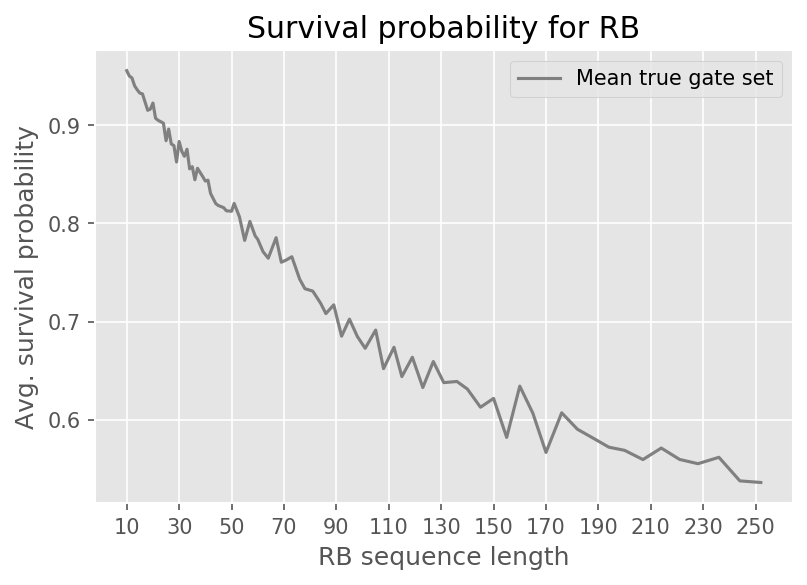

In [22]:
plt.plot(exp_lengths, true_mean_survival_probs, label='Mean true gate set', color='gray');
plt.legend()
plt.xticks(range(10, 252, 20))
plt.xlabel("RB sequence length")
plt.ylabel("Avg. survival probability")
plt.title("Survival probability for RB")

We see a nice decay curve! Now let's try and fit it to find the decay rate. 

Typically, RB curves are fit to something of the form $(A - B) p^m + B$, however this is done under the assumption that errors are gate-independent. Since each of our gates are button sequences, and the sequences vary in length, clearly this is not the case. However, in the interest of relating GST to pre-existing ideas in the field of RB, we will fit the curve anyways.

We cannot, however, perform a naive least-squares fit. An off-the-shelf least-squares fit assumes that the variance at every data point is the same. However, each point on this curve is the average over 100 different sequences, so we need to include this variance in the curve fitting procedure.

**Note**: When performed the fit, we constrained the values such that $A, B$ were within $[0, 1]$, and $p$ was within $[-0.5, 1]$, to be in line with what these quantities represent analytically (see paper).

In [23]:
from scipy.optimize import curve_fit

def RB_fit(m, A, B, p):
    return (A-B)*(p**m) + B

Text(0.5, 1.0, 'Survival probability for RB')

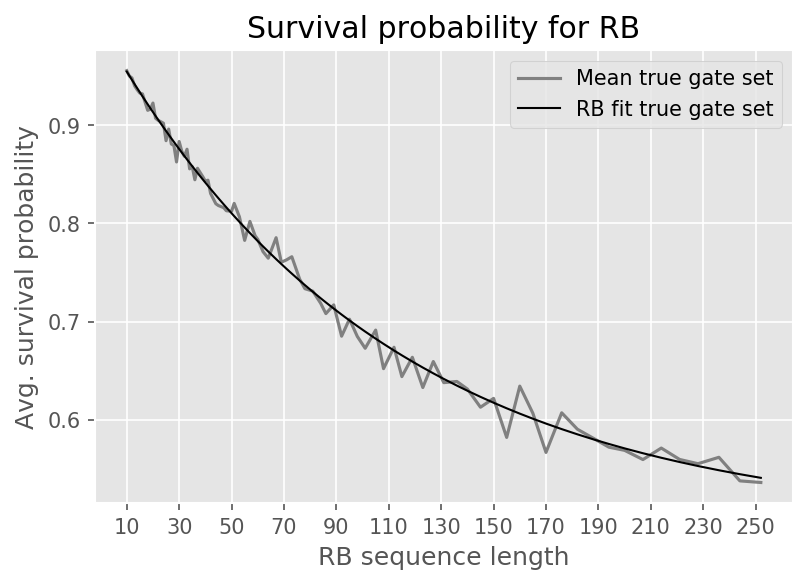

In [50]:
exp_qloss_true, stats = curve_fit(RB_fit, exp_lengths,  true_mean_survival_probs, 
                                 p0 = [0.6, 0.5, 0.5], 
                                 sigma=true_mean_survival_stds,
                                 bounds=([0, 0, -0.5], [1, 1, 1]))

plt.plot(exp_lengths, true_mean_survival_probs, label='Mean true gate set', color='gray');
plt.plot(exp_lengths, [RB_fit(x, *exp_qloss_true) for x in exp_lengths], color = 'black', linewidth=1, label = "RB fit true gate set")
plt.legend()
plt.xticks(range(10, 252, 20))
plt.xlabel("RB sequence length")
plt.ylabel("Avg. survival probability")
plt.title("Survival probability for RB")

In [25]:
exp_qloss_true

array([1.000459, 0.494175, 0.99062 ])

In [51]:
print(f"Decay rate p for 'true' gate set: {exp_qloss_true[2]}")
print(f"RB number for 'true' gate set: {(1+exp_qloss_true[2])/2}")

Decay rate p for 'true' gate set: 0.9906743868273555
RB number for 'true' gate set: 0.9953371934136778


Now we will perform the RB data analysis. Put everything into a Pandas data frame. I've included save/load functions - unless you ran this yourself, you can just load up the provided data file.

In [27]:
df.head()

pid  rb_length  gst_length      prob  success_prob
0  0.0       10.0        32.0  0.075278      0.924722
1  1.0       10.0        32.0  0.071688      0.928312
2  2.0       10.0        32.0  0.062762      0.937238
3  3.0       10.0        32.0  0.066772      0.933228
4  4.0       10.0        32.0  0.061395      0.938605

Let's plot the mean survival probability vs. sequence length for a handful of particles. 

Text(0.5, 1.0, 'Survival probability for RB with OQT posterior')

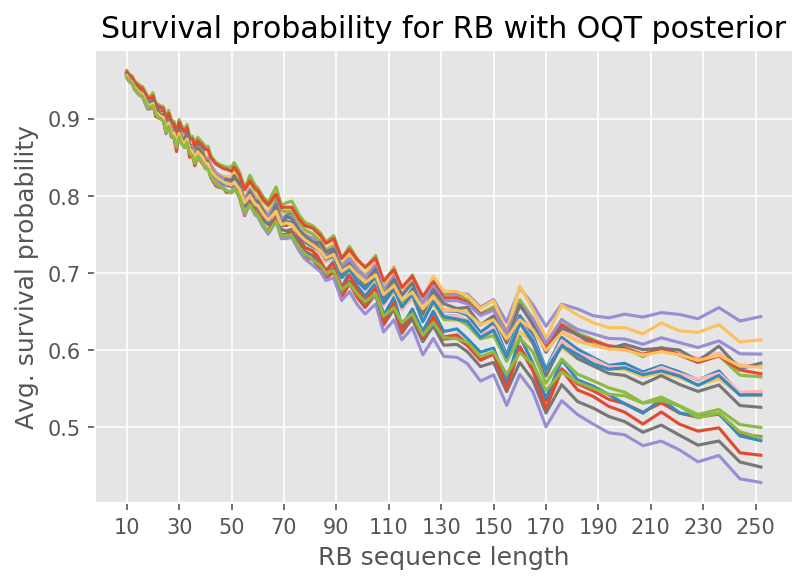

In [46]:
n_particles = 20
count = 0

for key, p_group in df.groupby(['pid']):
    if count == n_particles:
        break
    else:
        mean_line_particle = p_group.groupby('rb_length')['success_prob'].mean()
        plt.plot(exp_lengths, mean_line_particle)
        count += 1

plt.xticks(range(10, 252, 20))
plt.xlabel("RB sequence length")
plt.ylabel("Avg. survival probability")
plt.title("Survival probability for RB with OQT posterior")

Here we can see how the survival probabilities of the different particles diverge as the sequence length increases, though we note that they do seem to cluster a bit.

Next, compute the weighted mean over the mean lines of the individual particles using the particle weights from the posterior distribution.

In [30]:
mean_lines = []
for key, p_group in df.groupby(['pid']):
    mean_line_particle = p_group.groupby('rb_length')['success_prob'].mean()
    mean_lines.append(mean_line_particle)
    
# Now that we have means within each particle, take weighted mean over all particles
mean_lines_array = np.array(mean_lines)
mean_line = np.sum(np.tile(particle_weights, reps=(87, 1)).T * mean_lines_array, axis=0)

Text(0.5, 1.0, 'Survival probability for RB with OQT posterior')

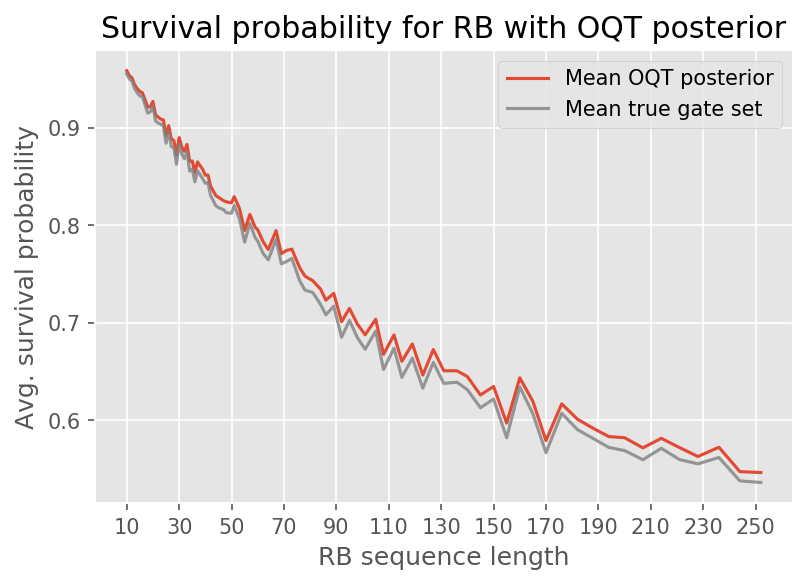

In [31]:
# Finally, lets plot the line vs. experiment length
plt.plot(exp_lengths, mean_line, label='Mean OQT posterior')
plt.plot(exp_lengths, true_mean_survival_probs, label='Mean true gate set', color='gray', alpha=0.8)

plt.legend()
plt.xticks(range(10, 252, 20))
plt.xlabel("RB sequence length")
plt.ylabel("Avg. survival probability")
plt.title("Survival probability for RB with OQT posterior")

### RB fit

In [39]:
# Run this cell to perform the curve fits yourself, otherwise
# run the next one to simply load the data
params = []

for key, p_group in df.groupby(['pid']):
    mean_line_particle = p_group.groupby('rb_length')['success_prob'].mean()
    # Weight by standard deviation at each sequence length
    std_line_particle = p_group.groupby('rb_length')['success_prob'].std()
    
    exp_qloss, stats = curve_fit(RB_fit, exp_lengths,  mean_line_particle, 
                                 p0 = [0.6, 0.5, 0.5], 
                                 sigma=std_line_particle,
                                 bounds=([0, 0, -0.5], [1, 1, 1]))
    params.append(exp_qloss)
    
df_params = pd.DataFrame(np.array(params), columns = ["A", "B", "p"])
df_params.to_csv(prefix + "params.csv", index=False)

In [33]:
# df_params = pd.read_csv(prefix + "params.csv")

In [40]:
df_params.head()

A         B         p
0  0.999744  0.427544  0.991598
1  0.998102  0.395640  0.992768
2  1.000000  0.306591  0.993354
3  0.999460  0.329899  0.993412
4  1.000000  0.493622  0.990818

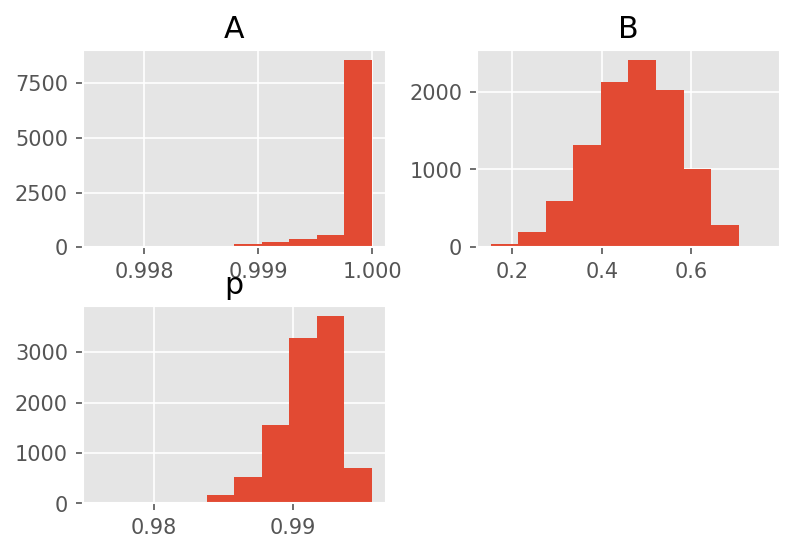

In [41]:
# Histogram of all the parameters
df_params.hist();

In [42]:
# Now average all of these parameters weighted by particle weight
a_mean = np.sum(particle_weights * df_params['A'])
b_mean = np.sum(particle_weights * df_params['B'])
p_mean = np.sum(particle_weights * df_params['p'])

In [43]:
print(f"Mean A = {a_mean:.6f}")
print(f"Mean B = {b_mean:.6f}")
print(f"Mean p = {p_mean:.6f}")

Mean A = 0.999916
Mean B = 0.481494
Mean p = 0.991119


In [44]:
# Fidelity, posterior mean
print(f"Mean fidelity = {(1 + p_mean) / 2:.6f}")

Mean fidelity = 0.995560


In [45]:
# Get 95% credible interval - use Bonferroni correction since we are
# looking for the interval over 3 parameters simultaneously
alpha = 0.95
low_bound = (1 - alpha/3)/2
up_bound = 1 - (1 - alpha/3)/2
print(df_params.quantile([low_bound, up_bound]))
print()
print(f"Fidelity lower bound = {(1 + df_params.quantile([low_bound, up_bound]).values[0, 2]) / 2:.6f}")
print(f"Fidelity upper bound = {(1 + df_params.quantile([low_bound, up_bound]).values[1, 2]) / 2:.6f}")

            A         B         p
0.341667  1.0  0.437793  0.990608
0.658333  1.0  0.517925  0.992230

Fidelity lower bound = 0.995304
Fidelity upper bound = 0.996115


Let's now plot the mean fitted curves:

Text(0.5, 1.0, 'Survival probability for RB with OQT posterior')

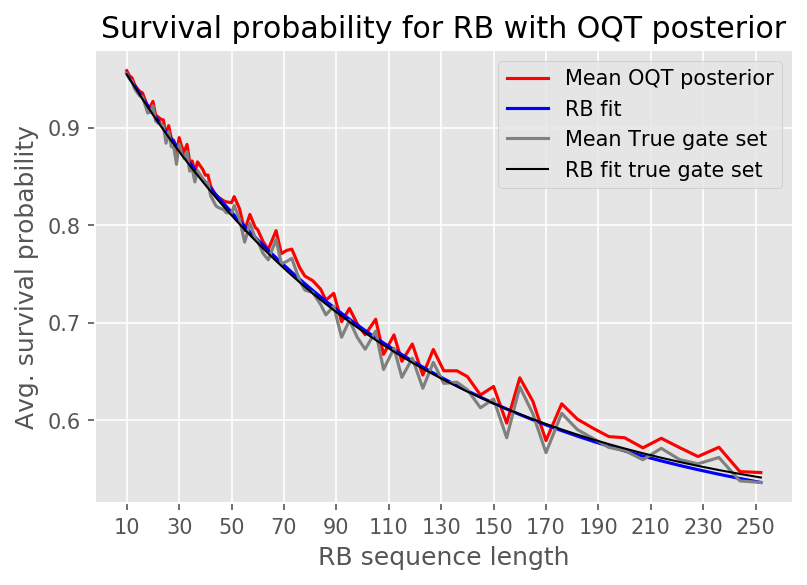

In [47]:
# Zeroth order
mean_params = [a_mean, b_mean, p_mean]
plt.plot(exp_lengths, mean_line, color = 'red', label = "Mean OQT posterior")
plt.plot(exp_lengths, [RB_fit(x, *mean_params) for x in exp_lengths], color = 'blue', label = "RB fit")

plt.plot(exp_lengths, true_mean_survival_probs, label='Mean True gate set', color='gray');
plt.plot(exp_lengths, [RB_fit(x, *exp_qloss_true) for x in exp_lengths], color = 'black', linewidth=1, label = "RB fit true gate set ")

plt.legend()
plt.xticks(range(10, 252, 20))
plt.xlabel("RB sequence length")
plt.ylabel("Avg. survival probability")
plt.title("Survival probability for RB with OQT posterior")

More important than a single curve is the credible region for the parameters $A, B, p$. To compute this we use a bootstrapping procedure as follows.

We compute the 95% credible region by finding the region in which 95% of the probability distribution lies.

Finally, let's plot everything together, including all the credible regions

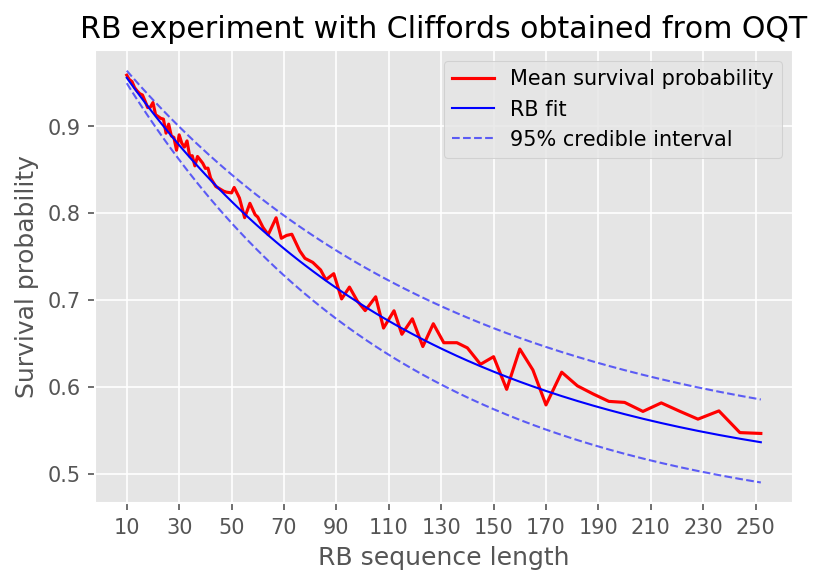

In [48]:
plt.plot(exp_lengths, mean_line, color = 'red', label = "Mean survival probability")
plt.plot(exp_lengths, [RB_fit(x, *mean_params) for x in exp_lengths], color = 'blue', linewidth=1, label = "RB fit")

for idx, alpha in enumerate([0.95]): # Loop in case you want to add more intervals
    low_bound = (1 - alpha/3) / 2
    up_bound = 1 - (1 - alpha/3) / 2
    bounds = df_params.quantile([low_bound, up_bound]).values
    lower_bound = bounds[0,:]
    upper_bound = bounds[1,:]
    
    lower_curve_points = [(x, RB_fit(x, *list(lower_bound))) for x in exp_lengths]
    upper_curve_points = [(x, RB_fit(x, *list(upper_bound))) for x in exp_lengths]

    plt.plot([x[0] for x in lower_curve_points], [x[1] for x in lower_curve_points], alpha=0.6, color="blue", linestyle='dashed', linewidth=1,  label="95% credible interval")
    plt.plot([x[0] for x in upper_curve_points], [x[1] for x in upper_curve_points], alpha=0.6, linewidth=1, linestyle='dashed', color="blue")

plt.xticks(range(10, 252, 20))
plt.xlabel("RB sequence length")
plt.ylabel("Survival probability")
plt.legend()
plt.title("RB experiment with Cliffords obtained from OQT")
plt.savefig("RB_credible.pdf")